In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load metadata
file_path = "C:/Data/DJ/azcopydata/midasmultimodalimagedatasetforaibasedskincancer/release_midas.xlsx"
df = pd.read_excel(file_path)

# Define image directory (same folder as the Excel sheet)
image_dir = os.path.dirname(file_path)

# Convert categorical columns to string before encoding
df = df.astype(str)

# Encode categorical variables
label_encoders = {}
categorical_cols = ['midas_gender', 'midas_fitzpatrick', 'midas_ethnicity', 'midas_race']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Convert numerical columns to float and handle errors
numerical_cols = ['midas_age', 'length_(mm)', 'width_(mm)']
df[numerical_cols] = df[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Normalize numerical variables
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols].fillna(0))

# Define target variable
df['target'] = df['midas_melanoma'].map({'yes': 1, 'no': 0})

# Remove rows with missing labels
df = df.dropna(subset=['target']).reset_index(drop=True)

# Debugging: Check unique label values and types
print("Unique label values:", df["target"].unique())
print("Label data type:", df["target"].dtype)

# Remove rows where the image file is missing
def file_exists(filename):
    possible_paths = [
        os.path.join(image_dir, filename),
        os.path.join(image_dir, filename.replace('.jpg', '.jpeg')),
        os.path.join(image_dir, filename.replace('.jpeg', '.jpg'))
    ]
    return any(os.path.exists(path) for path in possible_paths)

df = df[df['midas_file_name'].apply(file_exists)].reset_index(drop=True)

# Define dataset class
class MRAMIDASDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Load image with flexible file extension handling
        img_filename = row['midas_file_name']
        img_path = os.path.join(self.image_dir, img_filename)
        
        if not os.path.exists(img_path):
            # Try alternative extensions
            img_path_jpeg = img_path.replace('.jpg', '.jpeg')
            img_path_jpg = img_path.replace('.jpeg', '.jpg')
            if os.path.exists(img_path_jpeg):
                img_path = img_path_jpeg
            elif os.path.exists(img_path_jpg):
                img_path = img_path_jpg
            else:
                raise FileNotFoundError(f"Image not found: {img_filename}")
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Load metadata
        metadata_values = row[categorical_cols + numerical_cols].values.astype(float)
        metadata = torch.tensor(metadata_values, dtype=torch.float32)
        
        # Ensure label is an integer before creating tensor
        label = int(row['target'])  # Convert from potential object type
        label = torch.tensor(label, dtype=torch.int64)
        
        return image, metadata, label

# # Define image transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images
    transforms.RandomRotation(10),  # Small rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


labels = df['target'].values
class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[int(t)] for t in labels])
samples_weight = torch.tensor(samples_weight, dtype=torch.float)

sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
# Create dataset and dataloader
dataset = MRAMIDASDataset(df, image_dir, transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)



class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)  # Load pretrained EfficientNet-B0
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 128)  # Adjust output layer
    
    def forward(self, x):
        return self.model(x)


# # Define MLP for metadata processing
# class MetadataModel(nn.Module):
#     def __init__(self, input_size):
#         super(MetadataModel, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_size, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU()
#         )
    
#     def forward(self, x):
#         return self.fc(x)


class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.W = nn.Linear(input_dim, input_dim)
    
    def forward(self, x):
        attn_weights = F.softmax(self.W(x), dim=1)
        return x * attn_weights


class MetadataModel(nn.Module):
    def __init__(self, input_size):
        super(MetadataModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            AttentionLayer(128),  # Apply attention to highlight key features
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, 32)
        )

    def forward(self, x):
        return self.fc(x)



# Define Multimodal Model
class MultimodalModel(nn.Module):
    def __init__(self, image_model, metadata_model):
        super(MultimodalModel, self).__init__()
        self.image_model = image_model
        self.metadata_model = metadata_model
        self.classifier = nn.Linear(128 + 32, 2)  # Combining both feature sets
    
    def forward(self, image, metadata):
        img_features = self.image_model(image)
        meta_features = self.metadata_model(metadata)
        combined = torch.cat((img_features, meta_features), dim=1)
        return self.classifier(combined)
    


# Move model to GPU
image_model = ImageModel().to(device)
metadata_model = MetadataModel(input_size=len(categorical_cols) + len(numerical_cols)).to(device)
model = MultimodalModel(image_model, metadata_model).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5,gamma=0.5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print(f"Using device: {device}")
print(f"Class distribution:\n{df['target'].value_counts(normalize=True)}")
num_epochs = 5
for epoch in range(num_epochs):
    start_time = time.time()  # Start timer
    total_loss = 0
    correct, total = 0, 0
    print(f"Started epoch - {epoch+1}")

    for images, metadata, labels in dataloader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(torch.int64).to(device)
        model = model.to(device)  # Ensure model is on the correct device
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    accuracy = correct / total
    epoch_time = time.time() - start_time  # End timer

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f} seconds")


Unique label values: [0. 1.]
Label data type: float64
Using device: cpu
Class distribution:
target
0.0    0.802584
1.0    0.197416
Name: proportion, dtype: float64
Started epoch - 1


c:\Users\91935\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\91935\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 67.7035, Accuracy: 0.6367, Time: 686.91 seconds
Started epoch - 2
Epoch 2/5, Loss: 60.8496, Accuracy: 0.7127, Time: 585.06 seconds
Started epoch - 3
Epoch 3/5, Loss: 55.2402, Accuracy: 0.7749, Time: 854.40 seconds
Started epoch - 4
Epoch 4/5, Loss: 49.4430, Accuracy: 0.8245, Time: 800.75 seconds
Started epoch - 5
Epoch 5/5, Loss: 44.6136, Accuracy: 0.8573, Time: 690.02 seconds


In [3]:
# Define checkpoint save path
checkpoint_path = "C:/Data/DJ/SkinCancer/code/pytorch_models/mra_midas_efficientnetB0.pth"

num_additional_epochs = 10  # Additional training epochs
start_epoch = 5  # Last trained epoch
num_epochs = start_epoch + num_additional_epochs

for epoch in range(start_epoch, num_epochs):
    start_time = time.time()  # Start timer
    total_loss = 0
    correct, total = 0, 0
    print(f"Started epoch - {epoch+1}")

    for images, metadata, labels in dataloader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(torch.int64).to(device)
        
        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    accuracy = correct / total
    epoch_time = time.time() - start_time  # End timer

    scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}, Time: {epoch_time:.2f} seconds")

    # Save checkpoint after every epoch
    torch.save({
        'epoch': epoch+1,  # Save last completed epoch
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, checkpoint_path)

    print(f"Checkpoint saved at {checkpoint_path}")


Started epoch - 6
Epoch 6/15, Loss: 38.5564, Accuracy: 0.8888, Time: 746.67 seconds
Checkpoint saved at C:/Data/DJ/SkinCancer/code/pytorch_models/mra_midas_efficientnetB0.pth
Started epoch - 7
Epoch 7/15, Loss: 33.9598, Accuracy: 0.9300, Time: 758.03 seconds
Checkpoint saved at C:/Data/DJ/SkinCancer/code/pytorch_models/mra_midas_efficientnetB0.pth
Started epoch - 8
Epoch 8/15, Loss: 30.8988, Accuracy: 0.9435, Time: 691.38 seconds
Checkpoint saved at C:/Data/DJ/SkinCancer/code/pytorch_models/mra_midas_efficientnetB0.pth
Started epoch - 9
Epoch 9/15, Loss: 29.2800, Accuracy: 0.9591, Time: 687.63 seconds
Checkpoint saved at C:/Data/DJ/SkinCancer/code/pytorch_models/mra_midas_efficientnetB0.pth
Started epoch - 10
Epoch 10/15, Loss: 27.3326, Accuracy: 0.9721, Time: 832.35 seconds
Checkpoint saved at C:/Data/DJ/SkinCancer/code/pytorch_models/mra_midas_efficientnetB0.pth
Started epoch - 11
Epoch 11/15, Loss: 27.3619, Accuracy: 0.9697, Time: 812.86 seconds
Checkpoint saved at C:/Data/DJ/SkinCa

In [16]:
print(model)

MultimodalModel(
  (image_model): ImageModel(
    (model): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))


In [20]:
from torchsummary import summary

# Define input sizes correctly
image_input_size = (3, 224, 224)  # Image input
metadata_input_size = (len(categorical_cols) + len(numerical_cols),)  # Metadata input

# Print summaries separately
print("🔹 Image Model Summary:")
summary(image_model, input_size=(3, 224, 224))  # Image only

print("\n🔹 Metadata Model Summary:")
summary(metadata_model, input_size=(len(categorical_cols) + len(numerical_cols),))  # Metadata only

🔹 Image Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2

In [21]:
from torchinfo import summary

# Define sample inputs for image and metadata
batch_size = 1
image_shape = (batch_size, 3, 224, 224)
metadata_shape = (batch_size, len(categorical_cols) + len(numerical_cols))

# Print multimodal model summary
summary(model, input_size=[image_shape, metadata_shape], col_names=["input_size", "output_size", "num_params"])


Layer (type:depth-idx)                                            Input Shape               Output Shape              Param #
MultimodalModel                                                   [1, 3, 224, 224]          [1, 2]                    --
├─ImageModel: 1-1                                                 [1, 3, 224, 224]          [1, 128]                  --
│    └─EfficientNet: 2-1                                          [1, 3, 224, 224]          [1, 128]                  --
│    │    └─Sequential: 3-1                                       [1, 3, 224, 224]          [1, 1280, 7, 7]           4,007,548
│    │    └─AdaptiveAvgPool2d: 3-2                                [1, 1280, 7, 7]           [1, 1280, 1, 1]           --
│    │    └─Sequential: 3-3                                       [1, 1280]                 [1, 128]                  163,968
├─MetadataModel: 1-2                                              [1, 7]                    [1, 32]                   --
│    └─Sequenti

In [1]:
from torchviz import make_dot

# Get a sample input
sample_image = torch.randn(1, 3, 224, 224).to(device)
sample_metadata = torch.randn(1, len(categorical_cols) + len(numerical_cols)).to(device)
sample_output = model(sample_image, sample_metadata)

# Generate visualization
dot = make_dot(sample_output, params=dict(model.named_parameters()))
dot.render("model_visualization", format="png")  # Save as PNG

NameError: name 'torch' is not defined

In [29]:
import os
print(os.environ["PATH"])

c:\Users\91935\AppData\Local\Programs\Python\Python311;c:\Users\91935\AppData\Roaming\Python\Python311\Scripts;C:\Program Files (x86)\VMware\VMware Player\bin\;C:\ffmpeg\bin;C:\Program Files\Common Files\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Users\91935\AppData\Roaming\nvm;C:\Program Files\nodejs;C:\Users\91935\AppData\Local\Microsoft\WindowsApps;C:\Users\91935\AppData\Local\Programs\Microsoft VS Code\bin;C:\Users\91935\AppData\Roaming\npm;C:\Users\91935\AppData\Local\Programs\Python\Python311;C:\Users\91935\AppData\Local\Programs\Python\Python311\Scripts;C:\Program Files\sqlite;C:\Program Files\dotnet\;%SystemRoot%\system32;%SystemRoot%;%SystemRoot%\System32\Wbem;%SYSTEMROOT%\System32\WindowsPowerShell\v1.0\;%SYSTEMROOT%\System32\OpenSSH\;C:\Ruby33-x64\bin;C:\Users\91935\AppData\Local\Microsoft\WindowsApps;C:\Users\91935\AppData\Local\Programs\Mic

In [28]:
import graphviz
import torchviz
# print(torchviz.__version__)
print(graphviz.__version__)

0.20.3


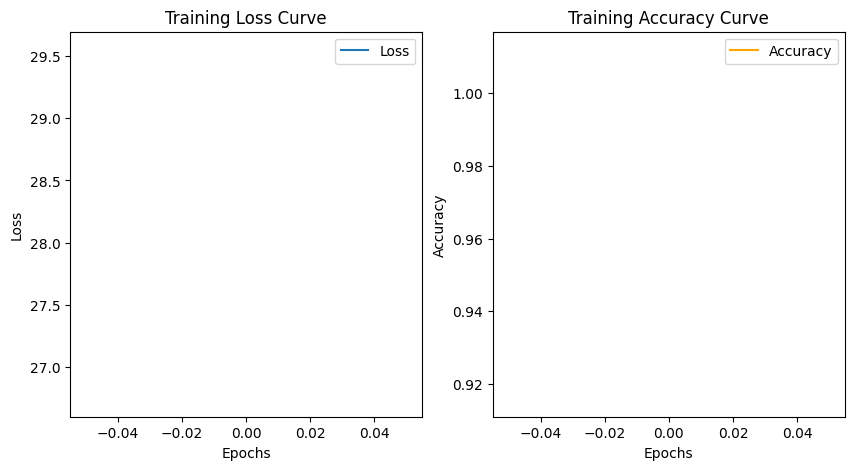

In [6]:
import matplotlib.pyplot as plt
loss_history = []
accuracy_history = []
# Inside training loop:
loss_history.append(total_loss)
accuracy_history.append(accuracy)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label="Accuracy", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Curve")
plt.legend()

plt.show()

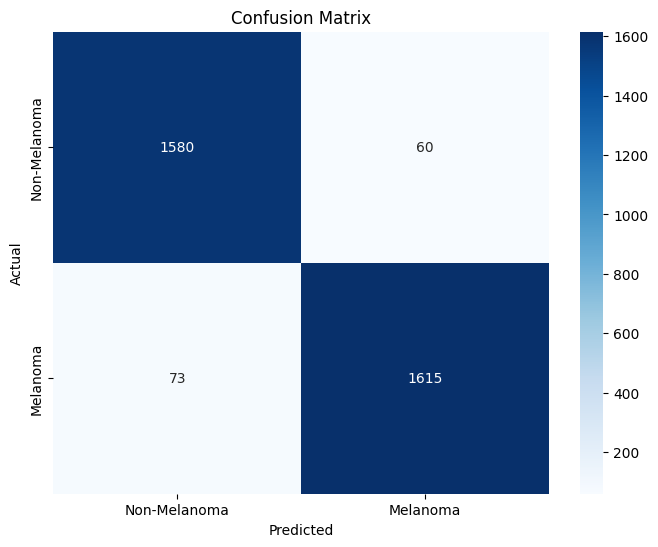

In [8]:
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, metadata, labels in dataloader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
        outputs = model(images, metadata)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Melanoma', 'Melanoma'], yticklabels=['Non-Melanoma', 'Melanoma'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Get counts for each class
non_melanoma_count = sum(conf_matrix[0])  # Sum of first row (Actual Non-Melanoma)
melanoma_count = sum(conf_matrix[1])      # Sum of second row (Actual Melanoma)

print(f"Number of Non-Melanoma samples: {non_melanoma_count}")
print(f"Number of Melanoma samples: {melanoma_count}")

Number of Non-Melanoma samples: 1640
Number of Melanoma samples: 1688


In [10]:
# Compute accuracy
correct_predictions = np.trace(conf_matrix)  # Sum of diagonal elements
total_samples = np.sum(conf_matrix)

accuracy = correct_predictions / total_samples
print(f"Model Accuracy: {accuracy:.4f}")  # Print accuracy with 4 decimal places

Model Accuracy: 0.9600


In [11]:
# Compute accuracy from labels and predictions
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)

accuracy = correct / total
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9600


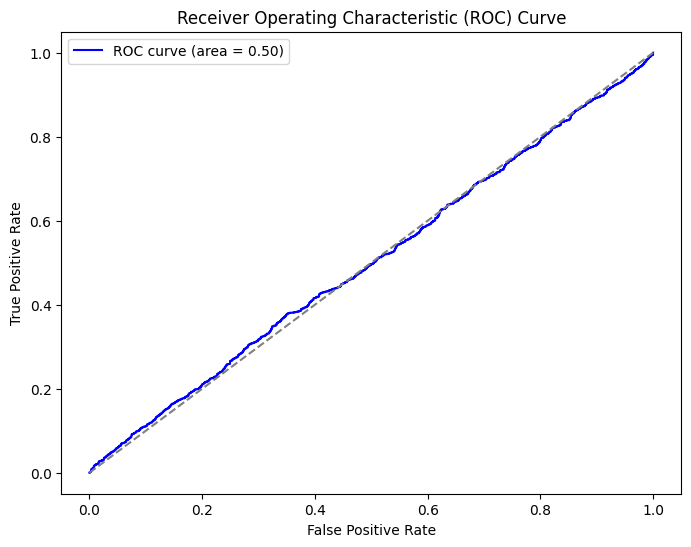

In [13]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get probability scores for ROC curve
all_probs = []

with torch.no_grad():
    for images, metadata, labels in dataloader:
        images, metadata = images.to(device), metadata.to(device)
        outputs = model(images, metadata)
        probs = torch.nn.functional.softmax(outputs, dim=1)[:,1]  # Probability of class 1 (Melanoma)
        all_probs.extend(probs.cpu().numpy())

# Compute ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

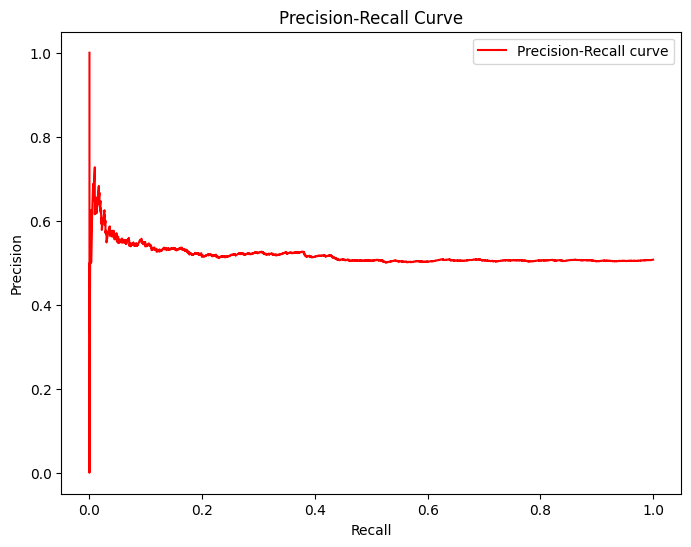

In [14]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='red', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

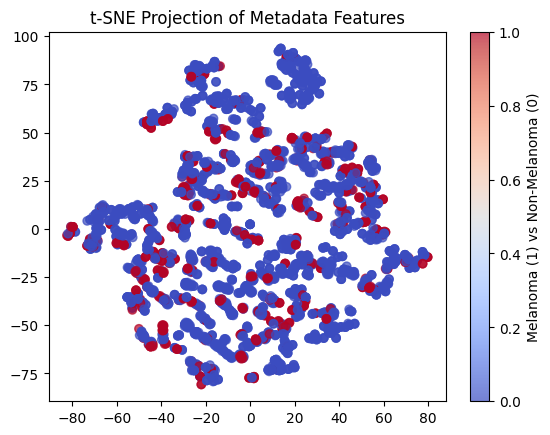

In [15]:
from sklearn.manifold import TSNE

metadata_embeddings = df[categorical_cols + numerical_cols].values
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(metadata_embeddings)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=df['target'].values, cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Melanoma (1) vs Non-Melanoma (0)")
plt.title("t-SNE Projection of Metadata Features")
plt.show()